# Hierarchical Clustering From Scratch

Agglomerative clustering with dendrogram visualization.

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)
np.random.seed(42)

---
## Agglomerative Clustering Implementation

In [2]:
class AgglomerativeClusteringSimple:
    def __init__(self, n_clusters=2, linkage='average'):
        self.n_clusters = n_clusters
        self.linkage = linkage
        self.labels_ = None
        self.merge_history_ = []
    
    def fit(self, X):
        n_samples = X.shape[0]
        
        # Initialize each point as its own cluster
        clusters = [[i] for i in range(n_samples)]
        
        # Compute initial distance matrix
        distances = squareform(pdist(X, metric='euclidean'))
        
        # Merge until we have desired number of clusters
        while len(clusters) > self.n_clusters:
            # Find closest pair of clusters
            min_dist = np.inf
            merge_i, merge_j = 0, 1
            
            for i in range(len(clusters)):
                for j in range(i + 1, len(clusters)):
                    dist = self._cluster_distance(clusters[i], clusters[j], distances)
                    if dist < min_dist:
                        min_dist = dist
                        merge_i, merge_j = i, j
            
            # Merge closest clusters
            new_cluster = clusters[merge_i] + clusters[merge_j]
            self.merge_history_.append((merge_i, merge_j, min_dist, len(new_cluster)))
            
            # Remove old clusters and add merged cluster
            clusters = [c for idx, c in enumerate(clusters) if idx not in (merge_i, merge_j)]
            clusters.append(new_cluster)
        
        # Assign labels
        labels = np.zeros(n_samples, dtype=int)
        for cluster_id, cluster in enumerate(clusters):
            for point_id in cluster:
                labels[point_id] = cluster_id
        
        self.labels_ = labels
        return self
    
    def _cluster_distance(self, cluster1, cluster2, distances):
        """Compute distance between two clusters based on linkage."""
        if self.linkage == 'single':
            # Minimum distance
            return min(distances[i, j] for i in cluster1 for j in cluster2)
        elif self.linkage == 'complete':
            # Maximum distance
            return max(distances[i, j] for i in cluster1 for j in cluster2)
        elif self.linkage == 'average':
            # Average distance
            return np.mean([distances[i, j] for i in cluster1 for j in cluster2])
    
    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

print('AgglomerativeClustering class ready')

AgglomerativeClustering class ready


---
## Generate Data

In [3]:
# Create 3 clusters
X, y_true = make_blobs(n_samples=150, centers=3, n_features=2, 
                       cluster_std=0.5, random_state=42)

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f'Data shape: {X.shape}')
print(f'True clusters: {len(np.unique(y_true))}')

Data shape: (150, 2)
True clusters: 3


---
## Test Different Linkages

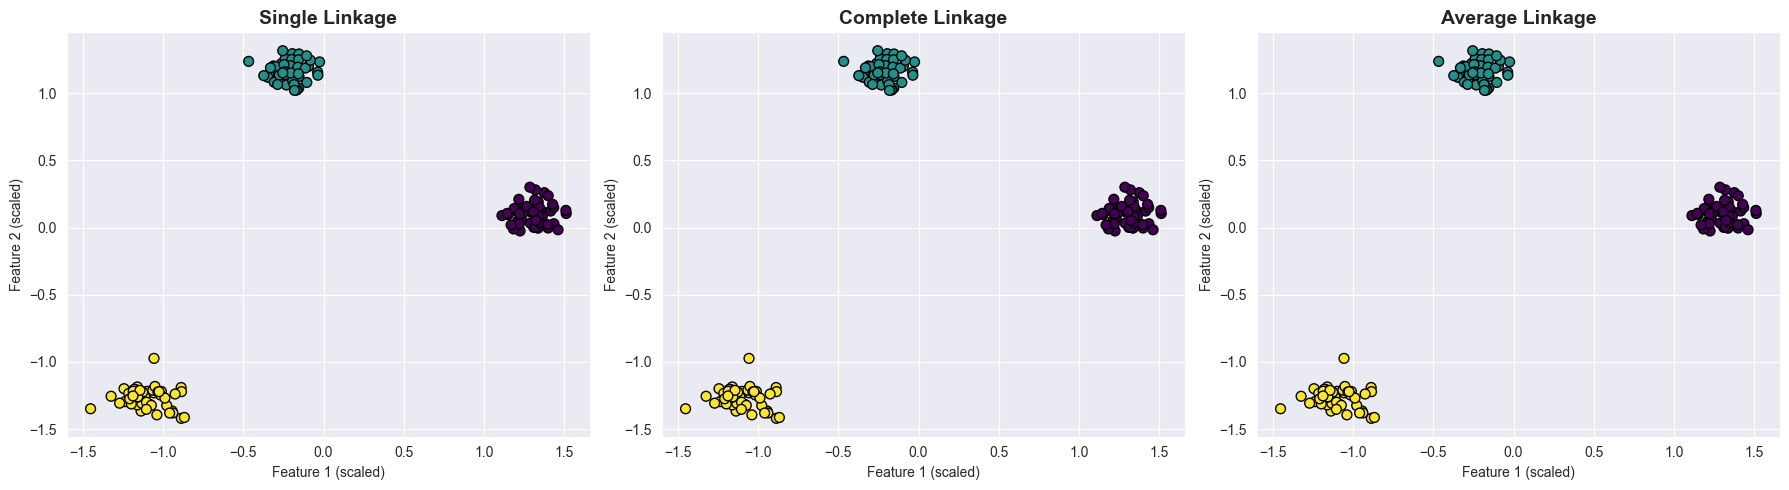

In [4]:
linkages = ['single', 'complete', 'average']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, link in enumerate(linkages):
    hc = AgglomerativeClusteringSimple(n_clusters=3, linkage=link)
    labels = hc.fit_predict(X_scaled)
    
    axes[idx].scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', 
                     s=50, edgecolors='k')
    axes[idx].set_title(f'{link.capitalize()} Linkage', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Feature 1 (scaled)')
    axes[idx].set_ylabel('Feature 2 (scaled)')

plt.tight_layout()
plt.show()

---
## Compare with sklearn

HIERARCHICAL CLUSTERING COMPARISON
Our clusters: 3
sklearn clusters: 3


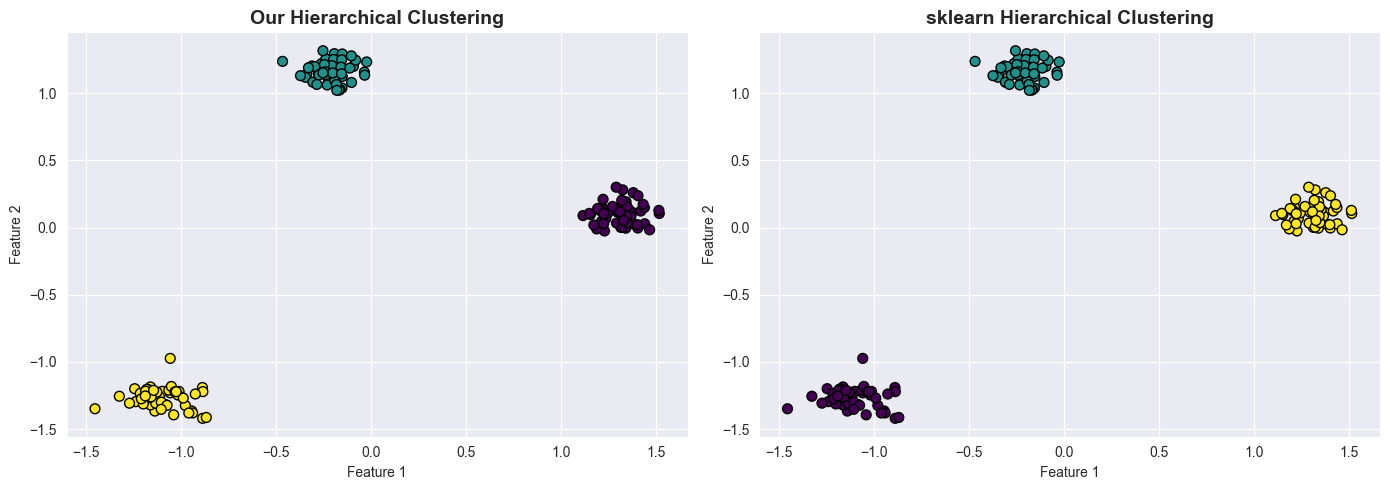

In [5]:
# Our implementation
our_hc = AgglomerativeClusteringSimple(n_clusters=3, linkage='average')
our_labels = our_hc.fit_predict(X_scaled)

# sklearn implementation
sklearn_hc = AgglomerativeClustering(n_clusters=3, linkage='average')
sklearn_labels = sklearn_hc.fit_predict(X_scaled)

print('='*60)
print('HIERARCHICAL CLUSTERING COMPARISON')
print('='*60)
print(f'Our clusters: {len(np.unique(our_labels))}')
print(f'sklearn clusters: {len(np.unique(sklearn_labels))}')

# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=our_labels, cmap='viridis', s=50, edgecolors='k')
axes[0].set_title('Our Hierarchical Clustering', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

axes[1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=sklearn_labels, cmap='viridis', s=50, edgecolors='k')
axes[1].set_title('sklearn Hierarchical Clustering', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

---
## Dendrogram Visualization

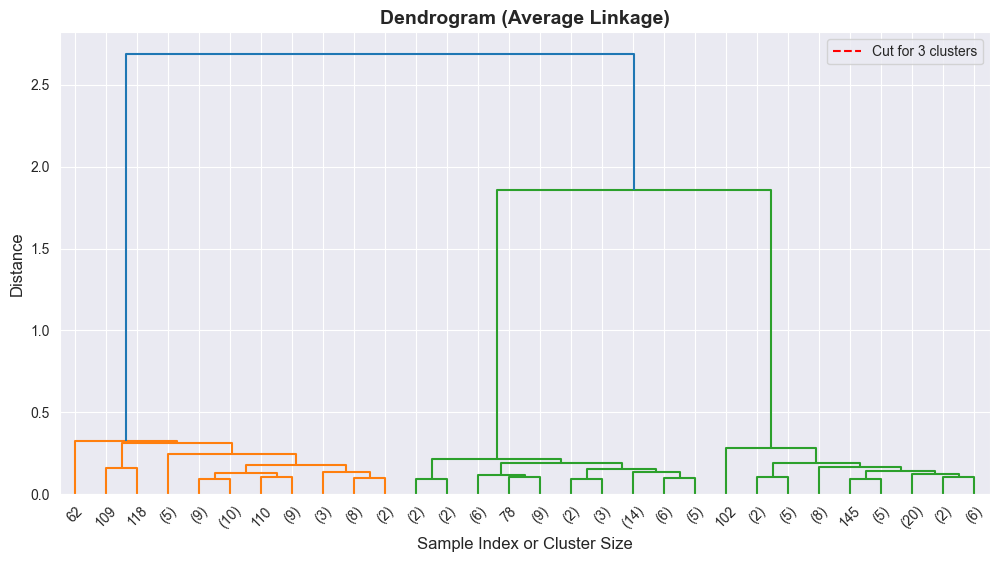

Horizontal line shows where to cut dendrogram for 3 clusters
Height of merge indicates dissimilarity between clusters


In [6]:
# Compute linkage matrix using scipy
Z = linkage(X_scaled, method='average')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='lastp', p=30, leaf_font_size=10)
plt.title('Dendrogram (Average Linkage)', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index or Cluster Size', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.axhline(y=3.5, color='r', linestyle='--', label='Cut for 3 clusters')
plt.legend()
plt.show()

print('Horizontal line shows where to cut dendrogram for 3 clusters')
print('Height of merge indicates dissimilarity between clusters')

---
## Compare Linkage Methods in Dendrogram

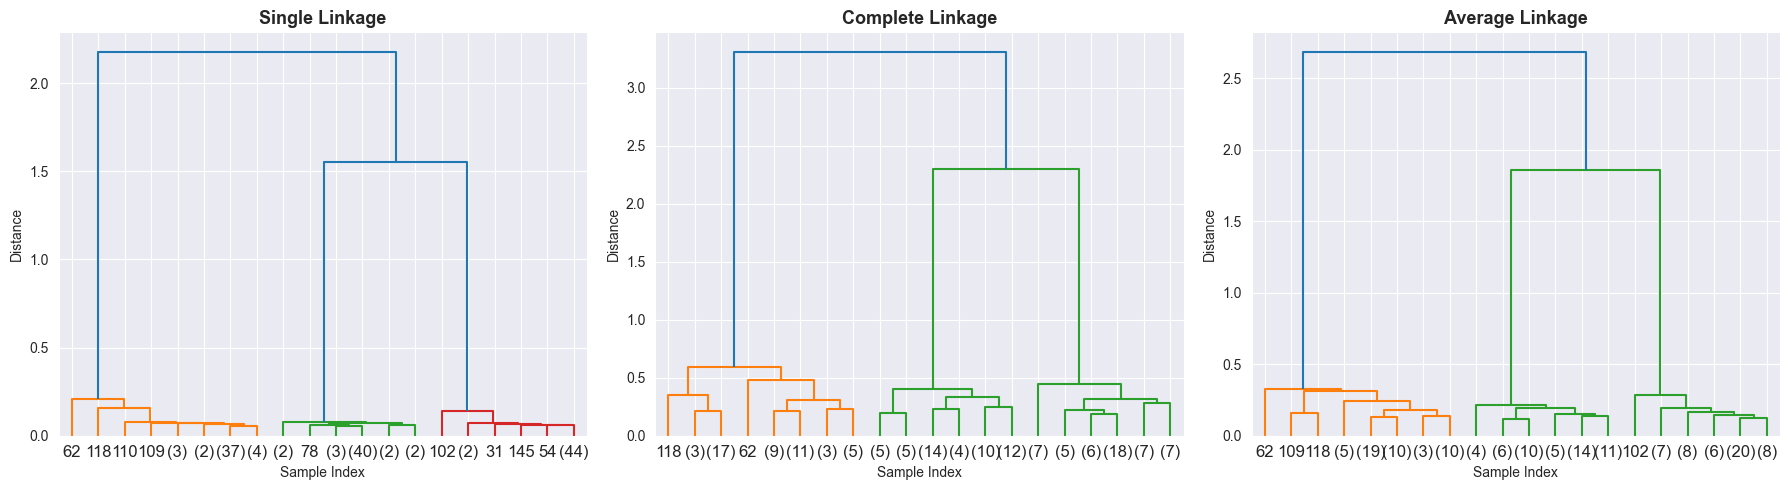

Single: Creates chain-like merges (lower heights)
Complete: Creates compact merges (higher heights)
Average: Balance between single and complete


In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
methods = ['single', 'complete', 'average']

for idx, method in enumerate(methods):
    Z_method = linkage(X_scaled, method=method)
    
    plt.sca(axes[idx])
    dendrogram(Z_method, truncate_mode='lastp', p=20)
    axes[idx].set_title(f'{method.capitalize()} Linkage', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('Sample Index')
    axes[idx].set_ylabel('Distance')

plt.tight_layout()
plt.show()

print('Single: Creates chain-like merges (lower heights)')
print('Complete: Creates compact merges (higher heights)')
print('Average: Balance between single and complete')

---
## Summary

**Key Points:**
- Hierarchical clustering builds tree of clusters
- Dendrogram shows full clustering hierarchy
- Linkage criterion affects cluster shape
- No need to specify K upfront
- Cut dendrogram at desired height for clusters

**Key Point:** "Hierarchical clustering iteratively merges closest clusters based on linkage criterion. Dendrogram visualization shows merge history and allows flexible cluster selection by cutting at any height."